# This notebook explores the variance in the imbalance of the Netherlands

In [9]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Load data
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']
dl = covid19_soccer.dataloader.Dataloader_gender(countries=countries)#


In [62]:
import datetime

def get_diff_in_imbalance(dl, ranges = None,time_var=True):
    """
    Get difference in imbalance from dataloader in one or multiple given
    time ranges. This is normalized to have a variance of 1
    
    Parameters
    ----------
    dl: dataloader
        
    ranges : list of list
        Ranges given
        default: [
            [2021-6-1, 2021-7-5] //Soccer
            [2021-4-25, 2021-5-30] //no-soccer
        ]
    
    Returns
    -------
    list of pd dataframes of imbalance values
    """
    if ranges is None:
        # Same number of days
        soccer = [
            datetime.datetime(2021,6,11),
            datetime.datetime(2021,7,16)
        ]
        no_soccer = [
            datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
            datetime.datetime(2021,6,10),
        ]
        ranges = [
            soccer, no_soccer
        ]
        
    cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
    cases = cases.loc[datetime.datetime(2021,1,1):datetime.datetime(2022,1,1),:]
    male_cases = cases.xs(key="male",level="gender")
    female_cases = cases.xs(key="female",level="gender")
    imbalance = ( male_cases / dl.population[0, :] - female_cases / dl.population[1, :] ) / ( female_cases / dl.population[1, :] + male_cases  / dl.population[0, :])
    

    if time_var:
        rolling_avg_imbalance = imbalance
        rolling_avg_imbalance = imbalance.rolling(4).mean().diff(4) #4=gen interval

        #Normalize range to variance -1,1 by divind with standard deviation
        mi = np.min(np.array(ranges))
        ma = np.max(np.array(ranges))
        rolling_avg_imbalance = rolling_avg_imbalance.loc[mi:ma]

        #return rolling_avg_imbalance
        ret = [rolling_avg_imbalance.loc[r[0]:r[1]] for r in ranges]
    else:
            #Normalize range to variance -1,1 by divind with standard deviation
        mi = np.min(np.array(ranges))
        ma = np.max(np.array(ranges))
        imbalance = imbalance.rolling(4).mean()
        imbalance = imbalance.loc[mi:ma]
        ret = [imbalance.loc[r[0]:r[1]] for r in ranges]
        
    return ret
    

def get_model_trace(soccer_var,no_soccer_var):
    """
    Get pymc3 model assuming same mean and same variance
    """
    with pm.Model() as model:
        # Data
        x1 = pm.Data("x1",soccer_var)
        x2 = pm.Data("x2",no_soccer_var)

        # Priors
        var = 1 # See normalization
        sigma1 = pm.Normal("sigma_1", mu=var, sigma=1)
        sigma2 = pm.Normal("sigma_2", mu=var, sigma=1)

        mu1 = pm.Uniform("mu1",-2,2)
        mu2 = pm.Uniform("mu2",-2,2)

        nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1

        soccer = pm.StudentT(
            "soccer",
            nu=nu,
            mu=mu1,
            sigma=sigma1,
            observed=x1
        )
        nonSoccer = pm.StudentT(
            "no-soccer",
            nu=nu,
            mu=mu2,
            sigma=sigma2,
            observed=x2
        )

        # Inference!
        # draw 3000 posterior samples using NUTS sampling
        trace = pm.sample(3000, return_inferencedata=True)
    return model, trace


In [63]:
imb = get_diff_in_imbalance(dl,time_var=False)


models = []
traces = []
for c in imb[0].columns:
    soccer_var = imb[0][c]
    no_soccer_var = imb[1][c]
    model, trace = get_model_trace(soccer_var,no_soccer_var)
    models.append(model)
    traces.append(trace)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
I

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_1': array(1.), 'sigma_2': array(1.), 'mu1_interval__': array(0.), 'mu2_interval__': array(0.), 'nu_minus_one_log__': array(3.00078291)}

Initial evaluation results:
sigma_1              -0.92
sigma_2              -0.92
mu1_interval__       -1.39
mu2_interval__       -1.39
nu_minus_one_log__   -1.06
soccer                 NaN
no-soccer              NaN
Name: Log-probability of test_point, dtype: float64

In [64]:
imb

[                  AT        BE        CZ        FR        DE        IT  \
 date                                                                     
 2021-06-11  0.033269  0.029884  0.012274 -0.025107  0.033329       NaN   
 2021-06-12  0.058367  0.029817 -0.004769 -0.030710  0.032038       NaN   
 2021-06-13  0.006428  0.050551 -0.023220 -0.021474  0.030707       NaN   
 2021-06-14  0.004630  0.034454  0.000446 -0.021147  0.041693  0.044584   
 2021-06-15  0.012455  0.064526 -0.002835 -0.024692  0.050159  0.037320   
 2021-06-16  0.019162  0.065398  0.042493 -0.022130  0.052902  0.042292   
 2021-06-17  0.005708  0.034396  0.062642 -0.030818  0.049815  0.035191   
 2021-06-18  0.009133  0.067842  0.051212 -0.027150  0.050469  0.010988   
 2021-06-19  0.047839  0.048459  0.047127 -0.017329  0.049455  0.004727   
 2021-06-20  0.051227  0.048459  0.054809 -0.010744  0.036054 -0.000863   
 2021-06-21  0.091433  0.057976  0.061457 -0.002036  0.062077 -0.005128   
 2021-06-22  0.093110  0.

In [289]:
from covid19_soccer.plot.timeseries import _uefa_range, _format_date_xticks

# Plot gender by date
fig, axes = plt.subplots(3,1,figsize=(7,3))

male_cases = cases.xs(key="male",level="gender")
female_cases = cases.xs(key="female",level="gender")
imbalance = male_cases/female_cases

axes[0].plot(male_cases)
axes[0].set_ylabel("Cases (male)")

axes[1].plot(female_cases)
axes[1].set_ylabel("Cases (female)")

axes[2].plot(imbalance)
axes[2].set_ylabel("Imbalance")

for ax in axes:
    ax.set_xlim(datetime(2021,1,1),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)
    
fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

TypeError: 'module' object is not callable

<ipython-input-60-767212d326f3>:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(["0.0","0.05","0.10"])
<ipython-input-60-767212d326f3>:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(["0.0","0.1","0.2"])


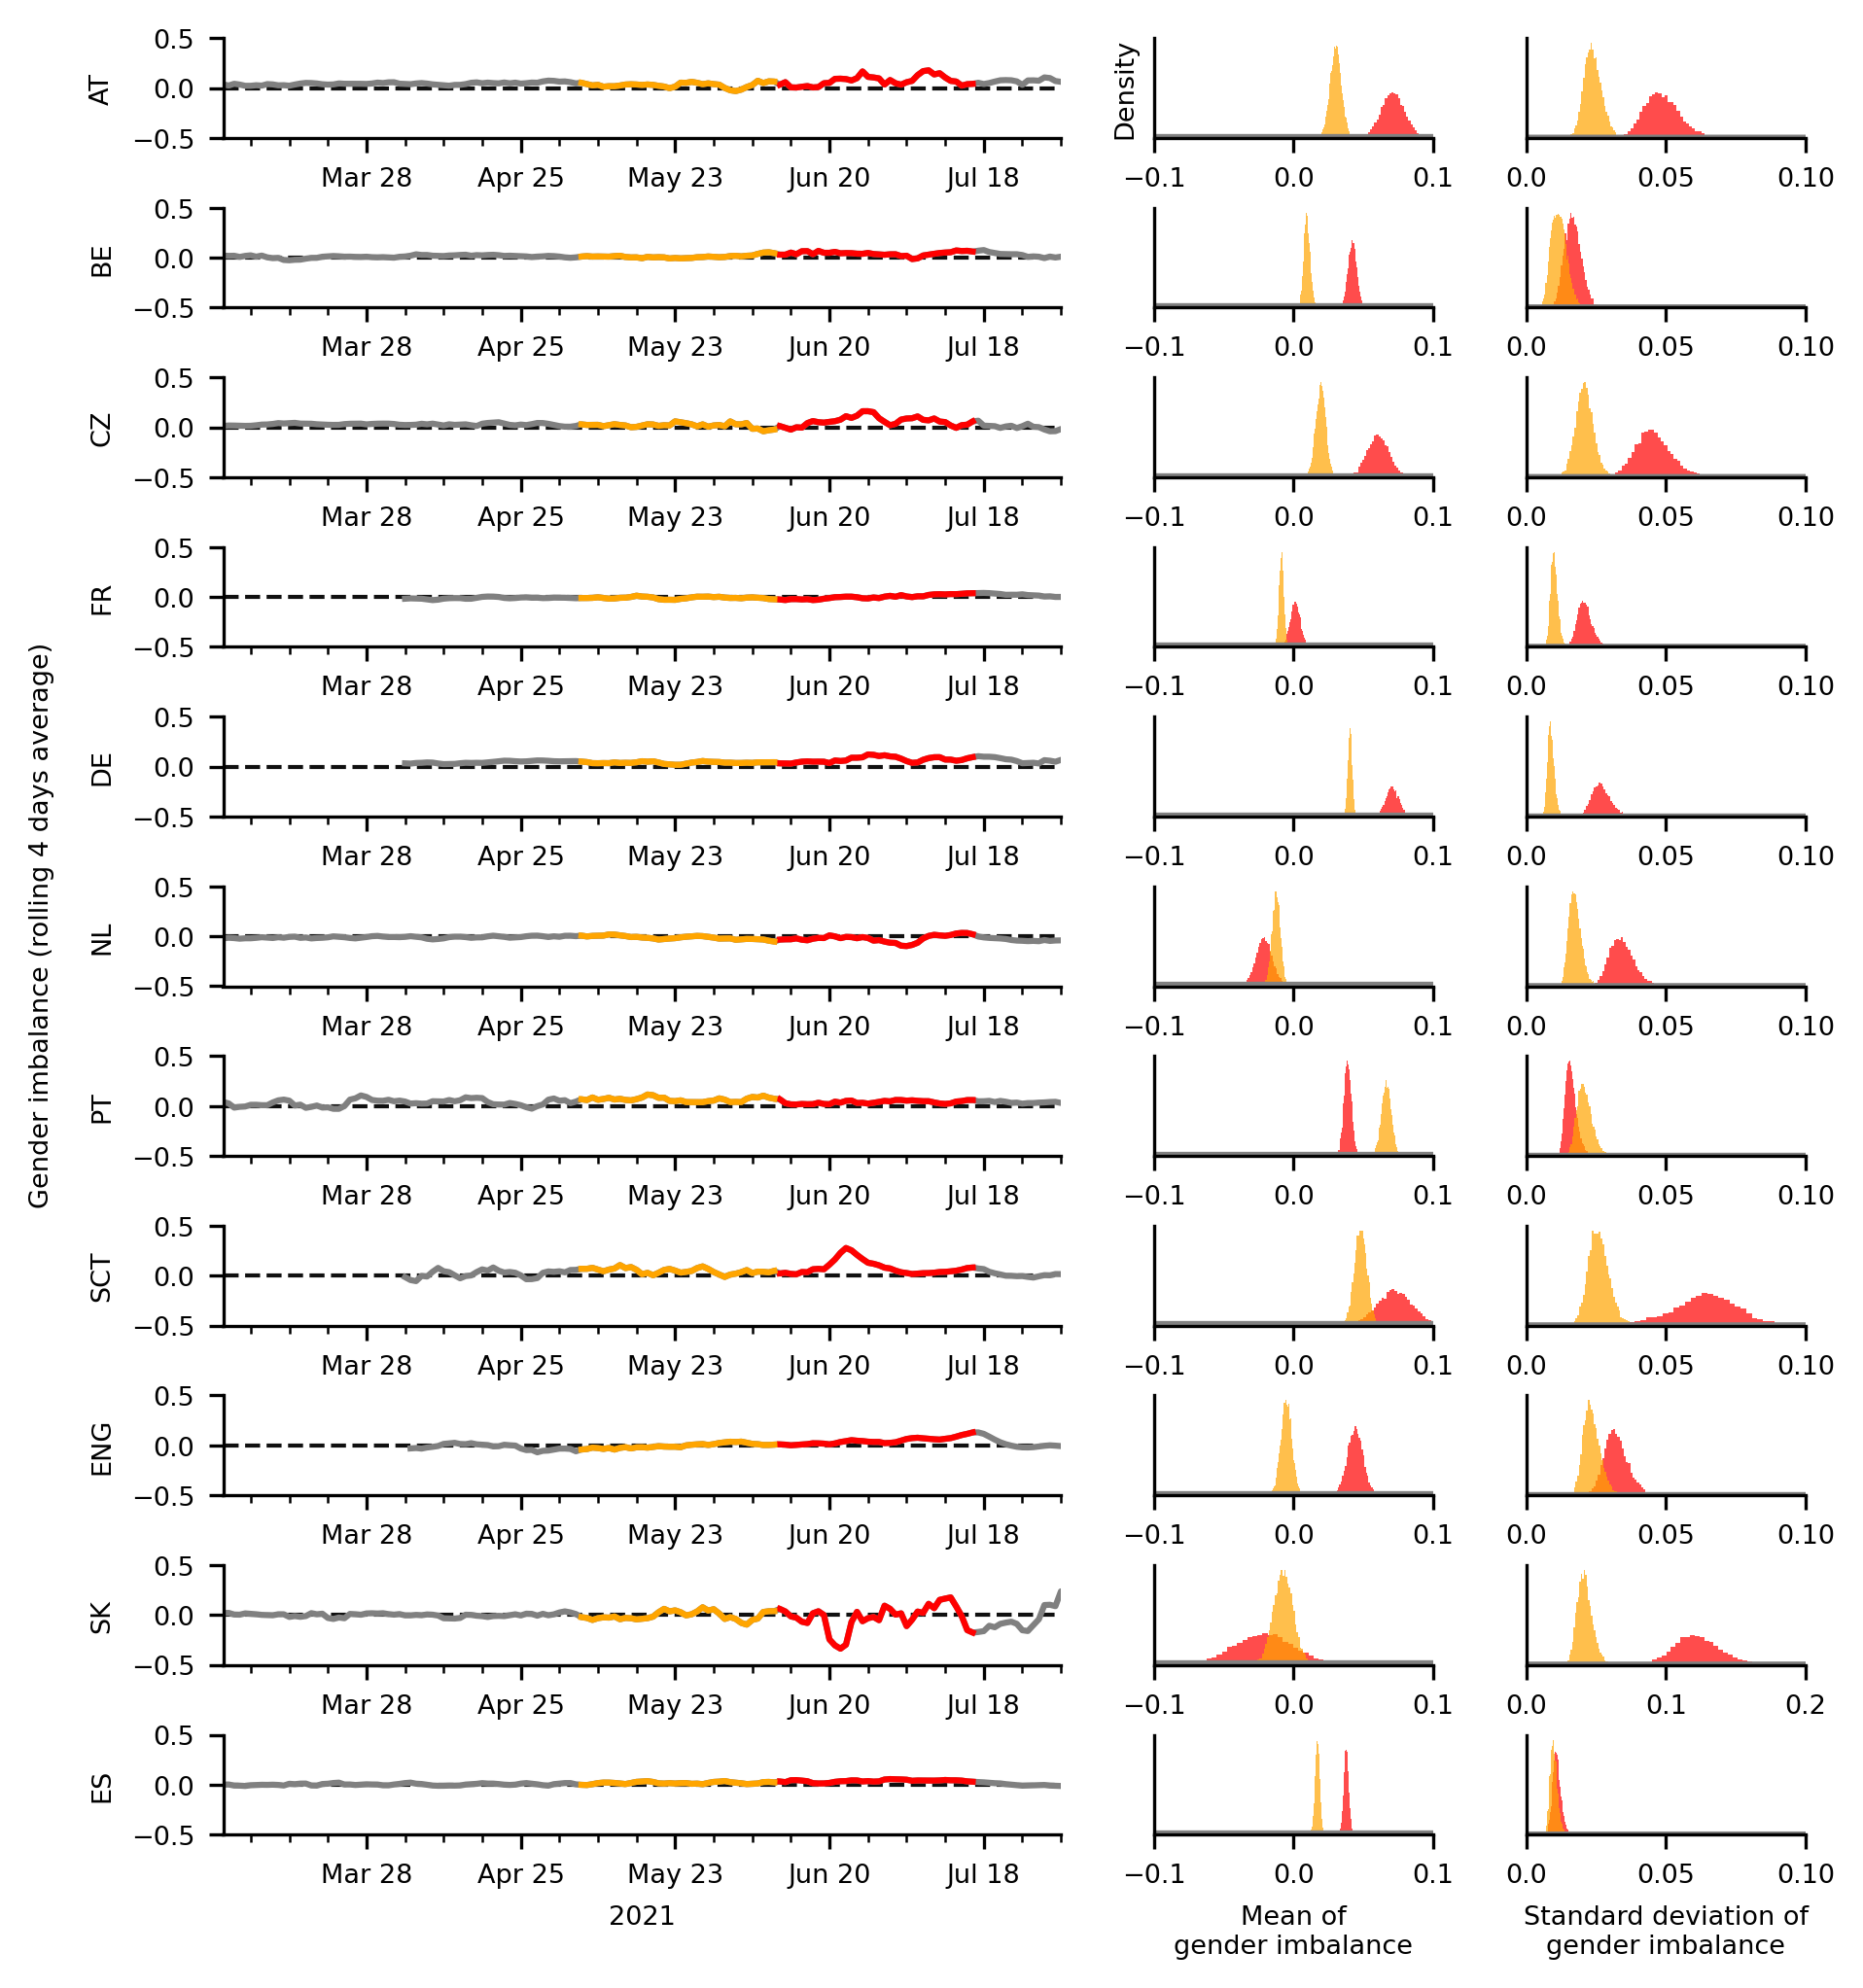

In [60]:
from matplotlib.patches import Patch
from covid19_soccer.plot.distributions import _plot_posterior, _plot_prior
from covid19_soccer.plot.timeseries import _uefa_range
from covid19_soccer.plot.utils import format_date_axis
from scipy.stats import norm
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')


def legend(ax, loc="best", ranges=None, **kwargs):
    
    if ranges is None:
        # Same number of days
        soccer = [
            datetime.datetime(2021,6,11),
            datetime.datetime(2021,7,16)
        ]
        no_soccer = [
            datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
            datetime.datetime(2021,6,10),
        ]
        ranges = [
            soccer, no_soccer
        ]
        
    lines = []
    labels = []
    lines.append(Patch([0], [0], color="red", lw=0,),)
    labels.append(f'From {soccer[0].strftime("%Y-%m-%d")} to {soccer[1].strftime("%Y-%m-%d")}')
    lines.append(Patch([0], [0], color="orange", lw=0,),)
    labels.append(f'From {no_soccer[0].strftime("%Y-%m-%d")} to {no_soccer[1].strftime("%Y-%m-%d")}')
    lines.append(Line2D([0], [0], color="gray", lw=2,))
    labels.append("Prior")
    ax.legend(lines,labels,loc=loc, **kwargs)
    
soccer = [
    datetime.datetime(2021,6,11),
    datetime.datetime(2021,7,16)
]
no_soccer = [
    datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
    datetime.datetime(2021,6,10),
]

cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
cases = cases.loc[datetime.datetime(2021,1,1):datetime.datetime(2022,1,1),:]
male_cases = cases.xs(key="male",level="gender")
female_cases = cases.xs(key="female",level="gender")
imbalance = ( male_cases / dl.population[0, :] - female_cases / dl.population[1, :] ) / ( female_cases / dl.population[1, :] + male_cases  / dl.population[0, :])
imbalance = imbalance.rolling(4).mean()

fig, axes = plt.subplots(11,3,figsize=(7,1*8),gridspec_kw={"hspace":0.7,"width_ratios":[0.6,0.2,0.2]})
for i,c in enumerate(imb[0].columns):
    trace=traces[i]
    
    """ Timeseries
    """
    ax = axes[i,0]
    
    ax.plot(imbalance[c],c="gray")
    ax.plot(imb[0][c],c="red")
    ax.plot(imb[1][c],c="orange")
    ax.set_xlim(datetime.datetime(2021,3,2),datetime.datetime(2021,8,1))
    format_date_axis(ax)

    
    """ mu
    """
    # Posterior
    ax = axes[i,1]
    _plot_posterior(trace.posterior["mu1"].to_numpy().flatten(),ax=ax,color="red")
    _plot_posterior(trace.posterior["mu2"].to_numpy().flatten(),ax=ax,color="orange")

    #Prior
    ax.axhline(0.1,lw=2,c="gray")
    
    """ Sigma
    """
    # Posterior
    ax = axes[i,2]
    _plot_posterior(trace.posterior["sigma_1"].to_numpy().flatten(),ax=ax,color="red")
    _plot_posterior(trace.posterior["sigma_2"].to_numpy().flatten(),ax=ax,color="orange")
    
    #Prior
    l = norm.ppf(0.001,1,1)
    u = norm.ppf(0.999,1,1)
    x = np.linspace(l,u, 1000)
    ax.plot(x,norm.pdf(x,1,1),c="tab:gray")
    

for i,c in enumerate(imb[0].columns):
    ax = axes[i,:]
    for a in ax[1:]:
        a.set_yticks([])
    ax[1].set_xlim(-0.1,0.1)
    ax[2].set_xlim(0,0.1)
    ax[2].set_xticklabels(["0.0","0.05","0.10"])
    
    # 0.0 line
    ax[0].axhline(0,ls="--",c="#101010",lw=1,zorder=-10)
    
    # Add label for country
    ax[0].set_ylabel(c.replace("GB-",""))
    ax[0].set_ylim(-0.5,0.5)
    if c == "SK":
        ax[2].set_xlim(0,0.2)
        ax[2].set_xticklabels(["0.0","0.1","0.2"])
    
    
fig.align_ylabels(axes)
axes[0,1].set_ylabel("Density")
fig.supylabel("Gender imbalance (rolling 4 days average)",x=0.03)
axes[-1,0].set_xlabel("2021")
axes[-1,1].set_xlabel("Mean of\ngender imbalance")
axes[-1,2].set_xlabel("Standard deviation of\ngender imbalance")

plt.show()
fig.savefig(f"../figures/SI/imbalance_analysis.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/imbalance_analysis.png", **save_kwargs)

In [279]:
imb = get_diff_in_imbalance(dl, time_var=False)

models = []
traces = []
for c in imb[0].columns:
    soccer_var = imb[0][c]
    no_soccer_var = imb[1][c]
    model, trace = get_model_trace(soccer_var,no_soccer_var)
    models.append(model)
    traces.append(trace)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu2, mu1, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...


KeyboardInterrupt: 

<ipython-input-271-2506b8ee318a>:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="red", lw=0,),)
<ipython-input-271-2506b8ee318a>:27: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="orange", lw=0,),)


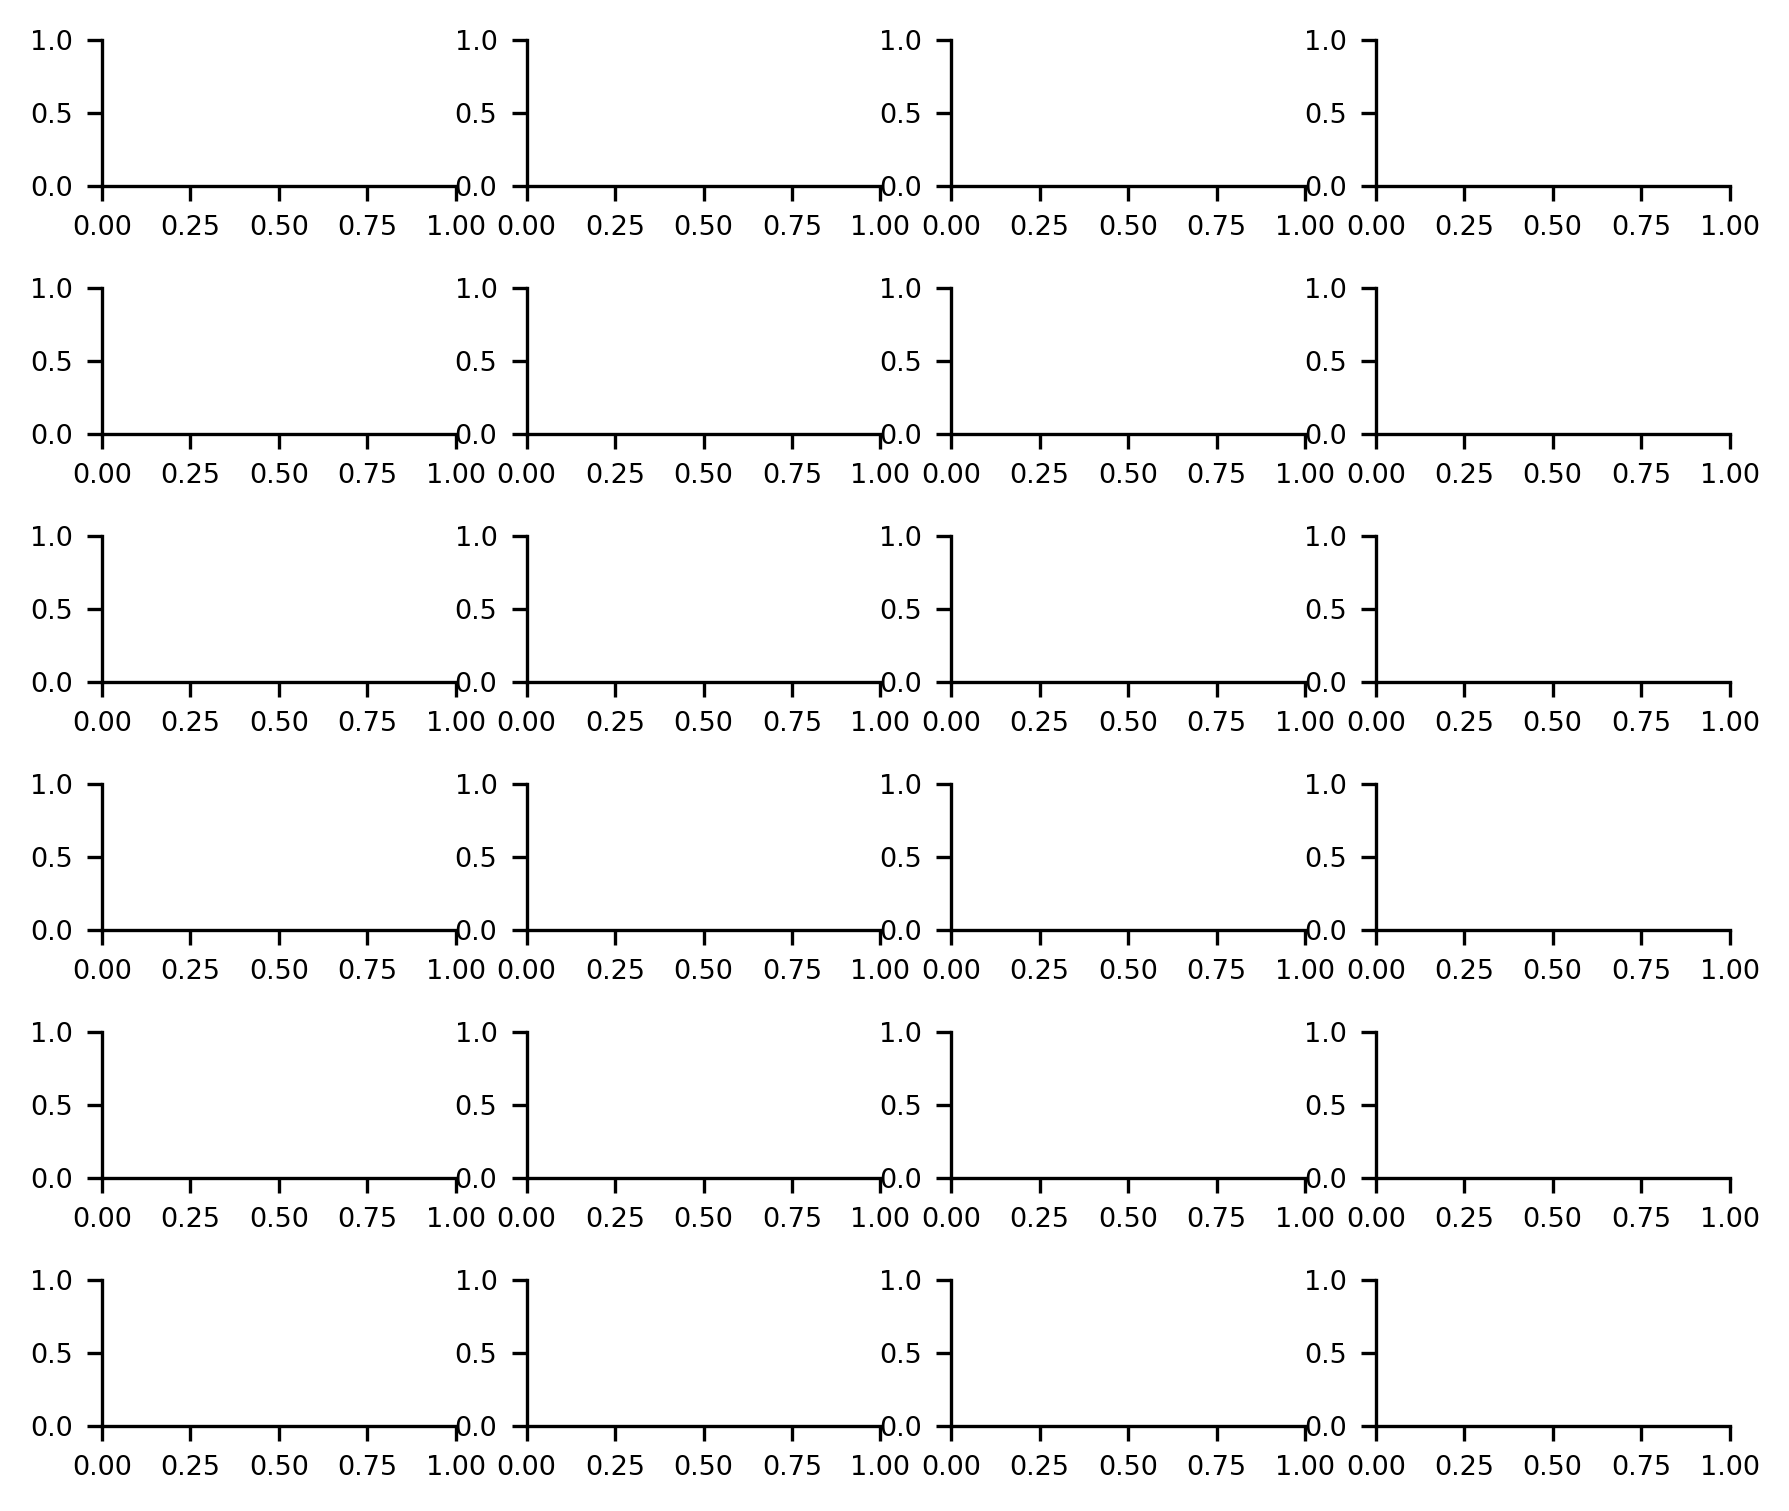

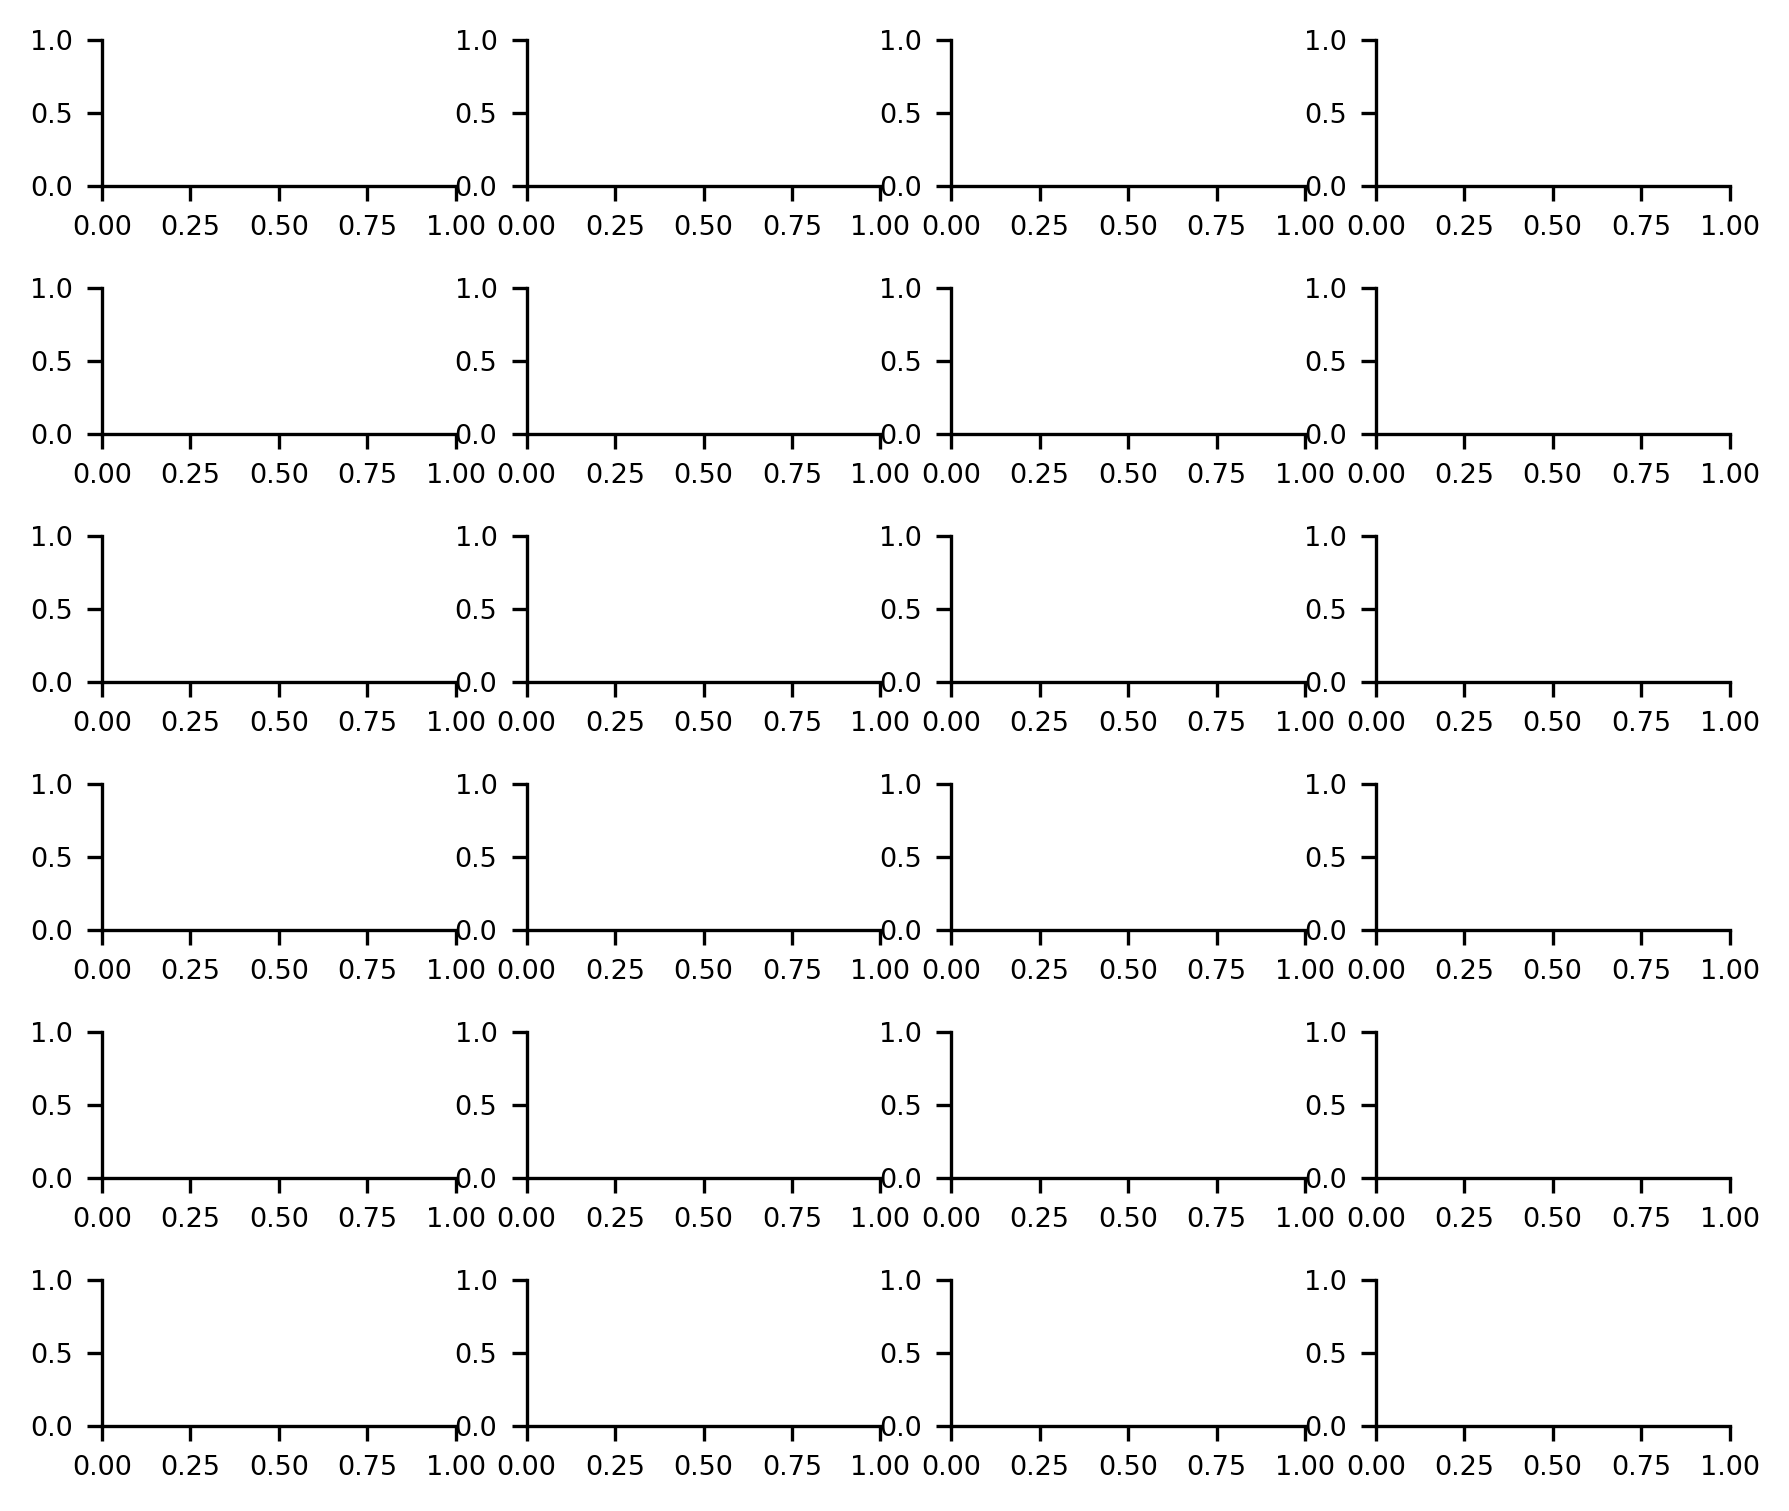

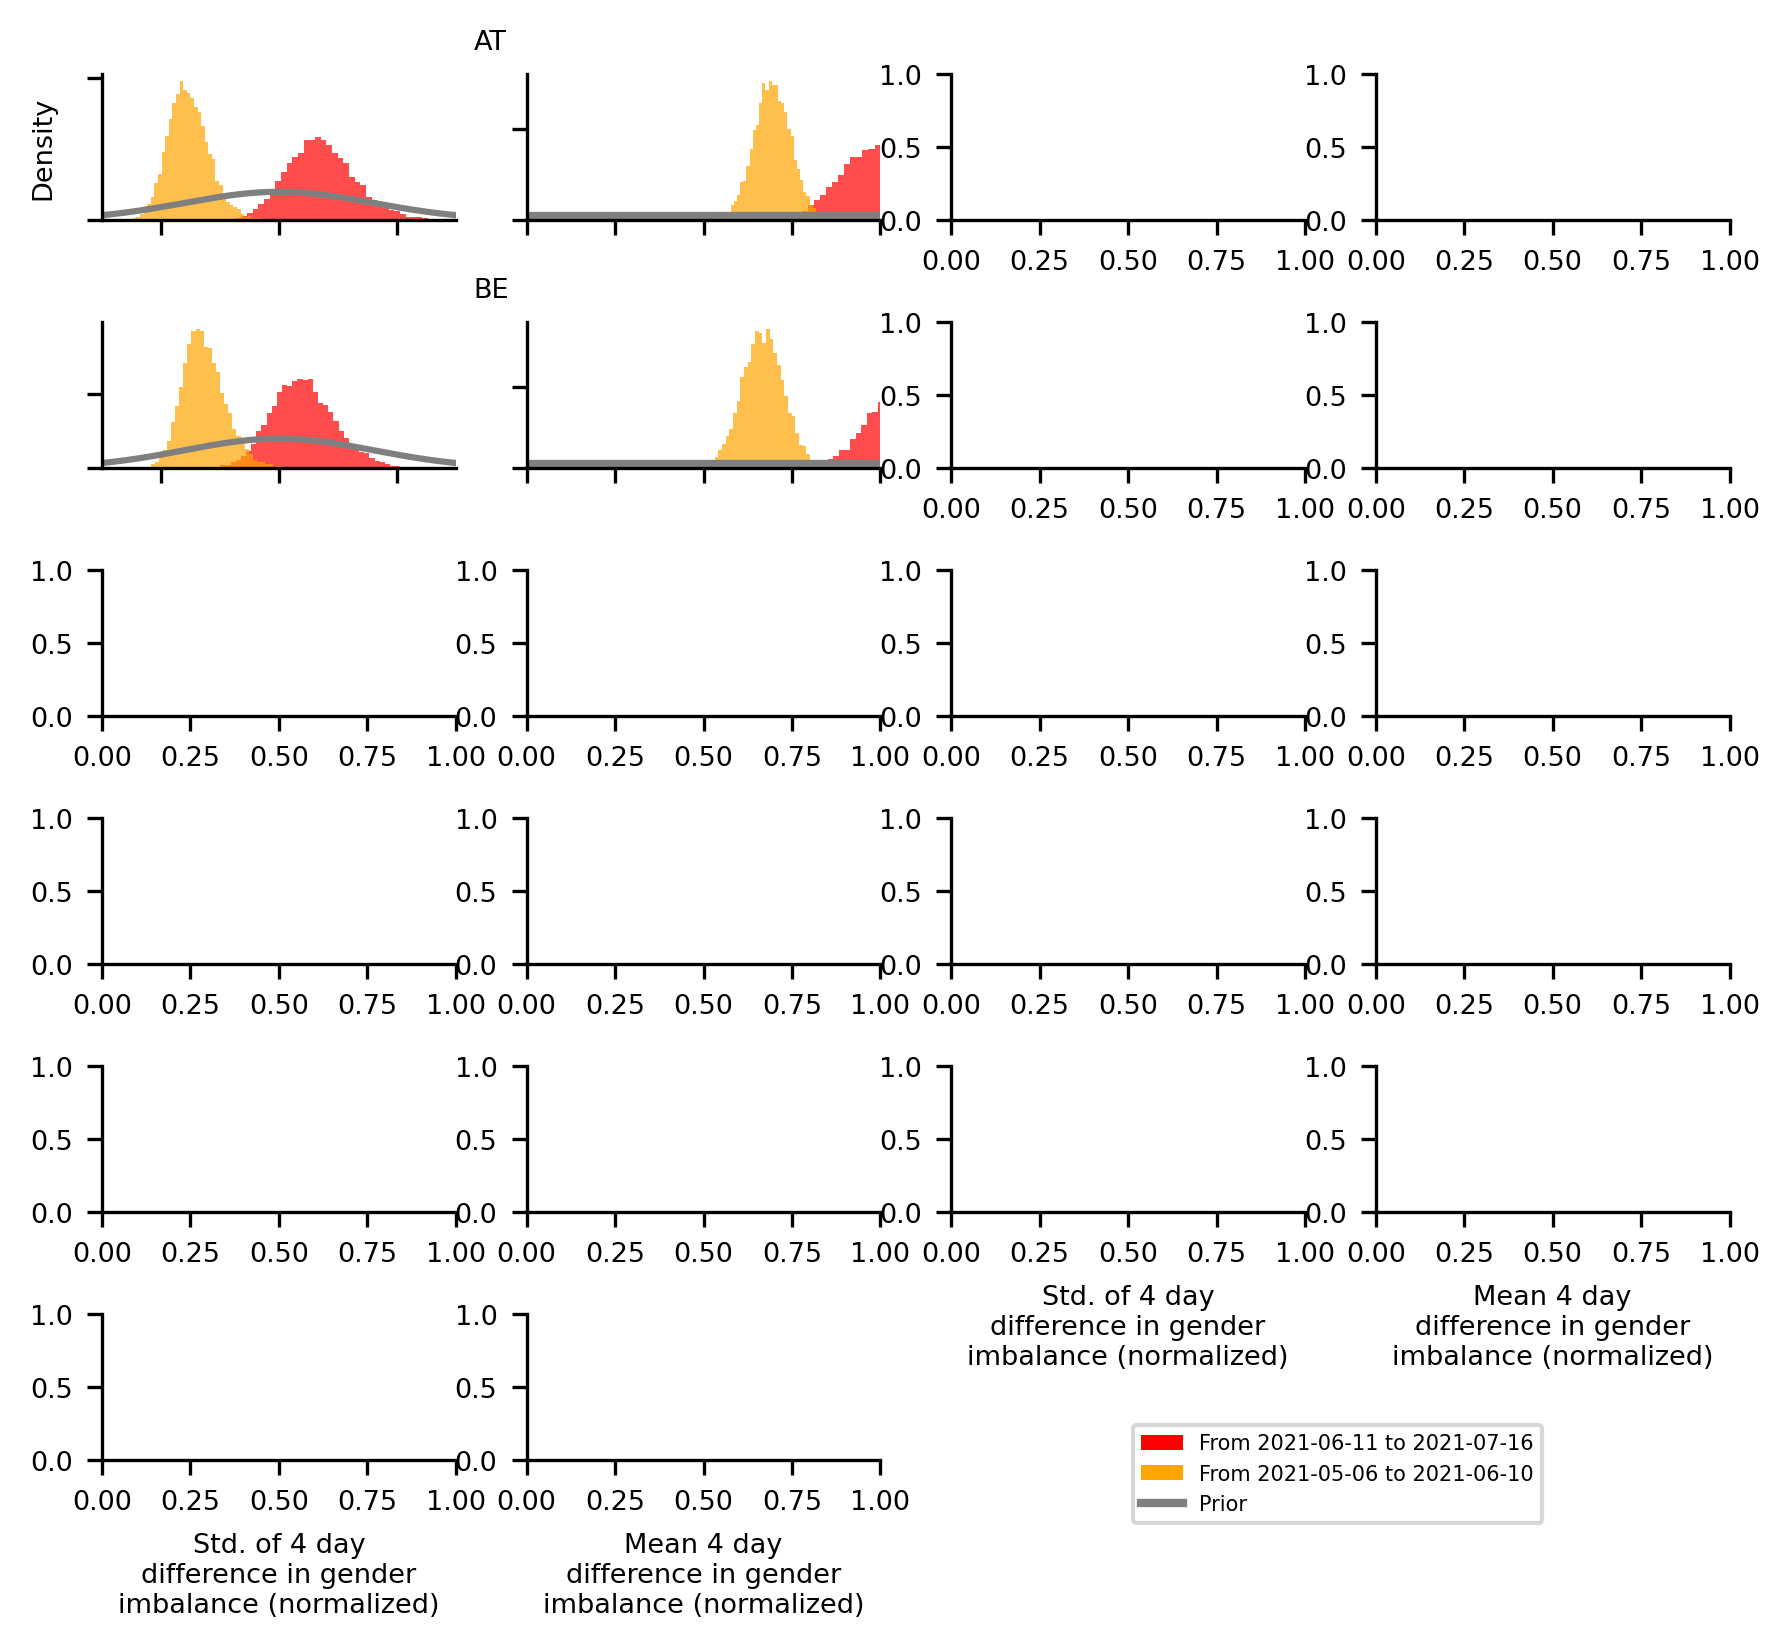

In [271]:
from matplotlib.patches import Patch
from covid19_soccer.plot.distributions import _plot_posterior, _plot_prior
from scipy.stats import norm
from matplotlib.lines import Line2D


def legend(ax, loc="best", ranges=None, **kwargs):
    
    if ranges is None:
        # Same number of days
        soccer = [
            datetime.datetime(2021,6,11),
            datetime.datetime(2021,7,16)
        ]
        no_soccer = [
            datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
            datetime.datetime(2021,6,10),
        ]
        ranges = [
            soccer, no_soccer
        ]
        
    lines = []
    labels = []
    lines.append(Patch([0], [0], color="red", lw=0,),)
    labels.append(f'From {soccer[0].strftime("%Y-%m-%d")} to {soccer[1].strftime("%Y-%m-%d")}')
    lines.append(Patch([0], [0], color="orange", lw=0,),)
    labels.append(f'From {no_soccer[0].strftime("%Y-%m-%d")} to {no_soccer[1].strftime("%Y-%m-%d")}')
    lines.append(Line2D([0], [0], color="gray", lw=2,))
    labels.append("Prior")
    ax.legend(lines,labels,loc=loc, **kwargs)
    
    
fig, axes = plt.subplots(6,4,figsize=(7,1*6),gridspec_kw={"hspace":0.7})
st=0
for i,c in enumerate(imb[0].columns[:2]):
    c = c.replace("GB-","")
    trace=traces[i]
    
    
    # Posterior
    ax = axes[i%6,0+st]
    _plot_posterior(trace.posterior["sigma_1"].to_numpy().flatten(),ax=ax,color="red")
    _plot_posterior(trace.posterior["sigma_2"].to_numpy().flatten(),ax=ax,color="orange")

    #Prior
    l = norm.ppf(0.001,1,0.4)
    u = norm.ppf(0.999,1,0.4)
    x = np.linspace(l,u, 1000)
    ax.plot(x,norm.pdf(x,1,0.4),c="tab:gray")
    
    #Markup
    if(i%6!=5 and st==0):
        ax.set_xticklabels([])
    if(i%6!=4 and st==2):
        ax.set_xticklabels([])
    ax.set_xlim(l,u)
    ax.set_yticklabels([])
    ax.set_xlim(0.25,1.75)
    
    ax.set_title(c,x=1.05,loc="left")

    
    # Posterior
    ax = axes[i%6,1+st]
    _plot_posterior(trace.posterior["mu1"].to_numpy().flatten(),ax=ax,color="red")
    _plot_posterior(trace.posterior["mu2"].to_numpy().flatten(),ax=ax,color="orange")

    #Prior
    ax.axhline(0.1,lw=2,c="gray")
    
    #Markup
    if(i%6!=5 and st==0):
        ax.set_xticklabels([])
    if(i%6!=4 and st==2):
        ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(-1,1)

    
    
    
    if(i==5):
        #stride
        st=2

axes[0,0].set_ylabel("Density")

axes[5,0].set_xlabel("Std. of 4 day\ndifference in gender\nimbalance (normalized)")
axes[5,1].set_xlabel("Mean 4 day\ndifference in gender\nimbalance (normalized)")

axes[4,2].set_xlabel("Std. of 4 day\ndifference in gender\nimbalance (normalized)")
axes[4,3].set_xlabel("Mean 4 day\ndifference in gender\nimbalance (normalized)")



for ax in axes[-1,-2:]:
    ax.axis("off")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

legend(axes[-1,-1],loc="lower right",bbox_to_anchor=(-0.5,-0.5,1,1))
fig.savefig(f"../figures/SI/imbalance_variance.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/imbalance_variance.png", **save_kwargs)
plt.show()

In [288]:
fig, axes = plt.subplots(3,1,figsize=(7,3))

rolling_avg_imbalance = imbalance.rolling(5).mean()

axes[0].plot(rolling_avg_imbalance)
axes[0].set_ylabel("Imbalance \n (rolling 5 days)")


axes[1].plot(rolling_avg_imbalance.diff(1))
axes[1].set_ylabel("Delta Imbalance \n (rolling 5 days diff)")
axes[1].set_ylim(-0.05,0.05)

for ax in axes:
    ax.set_xlim(datetime(2021,3,2),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)

fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

TypeError: 'module' object is not callable